# A4: Common Analysis for the COVID-19 Pandemic in St. Louis, Missouri

Goal: this analysis is for the pandemic impacts in the county of St. Louis, Missouri - How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 15, 2021?

In [8]:
!pip install plotly
!pip install numexpr

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)
%matplotlib inline
plt.style.use('ggplot')

## Data Acuisition

The data that we'll be using comes from the following sources:

1. This is a daily updating version of COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU).  https://www.arcgis.com/apps/dashboards/bda7594740fd40299423467b48e9ecf6 (Case Dashboard.)

2. U.S. State and Territorial Public Mask Mandates From April 10, 2020 through August 15 provided by the CDC.
https://data.cdc.gov/Policy-Surveillance/U-S-State-and-Territorial-Public-Mask-Mandates-Fro/62d6-pm5i

3. A repository by The New York Times containing estimates of mask usage by county in the United States. https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv

In [64]:
cases_by_county = pd.read_csv('./RAW_us_confirmed_cases.csv')
mask_mandates = pd.read_csv('U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv', parse_dates=['date'])
mask_compliance = pd.read_csv('mask-use-by-county.csv')

## Step 1. A look at the increase in COVID Cases over time for St. Louis county

before we model the increase in covid cases overtime, we have to do a bit of data cleaning first

In [10]:
# A brief look at the case by county dataframe
cases_by_county.head()

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/23/21,10/24/21,10/25/21,10/26/21,10/27/21,10/28/21,10/29/21,10/30/21,10/31/21,11/1/21
0,Alabama,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,...,10043,10047,10048,10061,10083,10219,10228,10239,10252,10258
1,Alabama,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,...,37245,37258,37266,37285,37325,37350,37372,37398,37414,37425
2,Alabama,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,...,3577,3578,3578,3583,3595,3596,3596,3599,3601,3601
3,Alabama,Bibb,84001007,US,USA,840,1007.0,US,32.996421,-87.125115,...,4251,4252,4253,4256,4262,4275,4276,4278,4279,4281
4,Alabama,Blount,84001009,US,USA,840,1009.0,US,33.982109,-86.567906,...,10192,10197,10207,10227,10338,10364,10371,10395,10406,10408


Before we go any further, let's see if there are any nulls/NaNs present in the dataframe

In [11]:
cases_by_county.isnull().sum()

Province_State    0
Admin2            6
UID               0
iso2              0
iso3              0
                 ..
10/28/21          0
10/29/21          0
10/30/21          0
10/31/21          0
11/1/21           0
Length: 661, dtype: int64

There are NaNs present for the Admin2 (County) variable. Let's replace them

In [12]:
cases_by_county['Admin2'] = cases_by_county['Admin2'].fillna('UNKNOWN')
cases_by_county.isnull().sum()

Province_State    0
Admin2            0
UID               0
iso2              0
iso3              0
                 ..
10/28/21          0
10/29/21          0
10/30/21          0
10/31/21          0
11/1/21           0
Length: 661, dtype: int64

Next we'll remove the individual date columns, the iso2 and iso3 columns, and rename columns so that the final dataframe will consist of 10 variables: State, County, UID, code3, FIPS, Country, Lat, Long, Date, and Count. 

In [13]:
cases_by_county = cases_by_county.melt(id_vars=['Province_State', 'Admin2', 'UID', 'code3', 'FIPS',
       'Country_Region', 'Lat', 'Long_'], var_name = 'Date', value_name = 'Count')

# renaming columns
cases_by_county = cases_by_county.rename(columns = {'Province_State':'State'})
cases_by_county = cases_by_county.rename(columns = {'Admin2':'County'})
cases_by_county = cases_by_county.rename(columns = {'Long_':'Long'})
cases_by_county = cases_by_county.rename(columns = {'Country_Region': 'Country'})

cases_by_county.head()

,State,County,UID,code3,FIPS,Country,Lat,Long,Date,Count
0,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,iso2,US
1,Alabama,Baldwin,84001003,840,1003.0,US,30.727750,-87.722071,iso2,US
2,Alabama,Barbour,84001005,840,1005.0,US,31.868263,-85.387129,iso2,US
3,Alabama,Bibb,84001007,840,1007.0,US,32.996421,-87.125115,iso2,US
4,Alabama,Blount,84001009,840,1009.0,US,33.982109,-86.567906,iso2,US


In [16]:
# Again, check for NaNs
cases_by_county.isnull().sum()

State         0
County        0
UID           0
code3         0
FIPS       6530
Country       0
Lat           0
Long          0
Date          0
Count         0
dtype: int64

In [17]:
# Replace NaNs for the FIPS column
cases_by_county['FIPS'] = cases_by_county['FIPS'].fillna(0).astype(str)
cases_by_county.isnull().sum()

State      0
County     0
UID        0
code3      0
FIPS       0
Country    0
Lat        0
Long       0
Date       0
Count      0
dtype: int64

We'll do some further cleaning up of this dataframe. We'll remove rows that don't have a defined date (i.e. Date == "Combined Key") and add two columns representing the year and date for the ones that do

In [20]:
cases_by_county = cases_by_county[(cases_by_county['Date'] != 'Combined_Key')]
cases_by_county = cases_by_county[(cases_by_county['Date'] != 'iso2')]
cases_by_county = cases_by_county[(cases_by_county['Date'] != 'iso3')]


cases_by_county['year'] = cases_by_county['Date'].str[-2:]
cases_by_county['month'] = cases_by_county['Date'].str[-8:-6]
cases_by_county.head(10)

,State,County,UID,code3,FIPS,Country,Lat,Long,Date,Count,year,month
10026,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,1/22/20,0,20,1
10027,Alabama,Baldwin,84001003,840,1003.0,US,30.727750,-87.722071,1/22/20,0,20,1
10028,Alabama,Barbour,84001005,840,1005.0,US,31.868263,-85.387129,1/22/20,0,20,1
10029,Alabama,Bibb,84001007,840,1007.0,US,32.996421,-87.125115,1/22/20,0,20,1
10030,Alabama,Blount,84001009,840,1009.0,US,33.982109,-86.567906,1/22/20,0,20,1
10031,Alabama,Bullock,84001011,840,1011.0,US,32.100305,-85.712655,1/22/20,0,20,1
10032,Alabama,Butler,84001013,840,1013.0,US,31.753001,-86.680575,1/22/20,0,20,1
10033,Alabama,Calhoun,84001015,840,1015.0,US,33.774837,-85.826304,1/22/20,0,20,1
10034,Alabama,Chambers,84001017,840,1017.0,US,32.913601,-85.390727,1/22/20,0,20,1
10035,Alabama,Cherokee,84001019,840,1019.0,US,34.178060,-85.606390,1/22/20,0,20,1


In [21]:
#update data type to object or int64
cases_by_county = cases_by_county.astype({'UID': str
                , 'code3': str
                , 'FIPS': str
                , 'Count': int
               })
#update data type to date -> 01/29/21 => 2021-01-29
cases_by_county['Date'] = pd.to_datetime(cases_by_county['Date'], format="%m/%d/%y")

#sort in order
cases_by_county = cases_by_county.sort_values(by=['State', 'County', 'Date'])
cases_by_county.head(10)

,State,County,UID,code3,FIPS,Country,Lat,Long,Date,Count,year,month
10026,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-22,0,20,1
13368,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-23,0,20,1
16710,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-24,0,20,1
20052,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-25,0,20,1
23394,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-26,0,20,1
26736,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-27,0,20,1
30078,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-28,0,20,1
33420,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-29,0,20,1
36762,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-30,0,20,1
40104,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-31,0,20,1


Now that we've sorted the dataframe, let's add a column that records the incremental increase in the number of cases.

In [23]:
#retrieve incremental number of cases
cases_by_county['Case_Increment'] = cases_by_county['Count'].diff()
cases_by_county = cases_by_county.fillna(0)

#update data type
cases_by_county['Case_Increment'] = cases_by_county['Case_Increment'].astype(int)
cases_by_county.head(10)

,State,County,UID,code3,FIPS,Country,Lat,Long,Date,Count,year,month,Case_Increment
10026,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-22,0,20,1,0
13368,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-23,0,20,1,0
16710,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-24,0,20,1,0
20052,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-25,0,20,1,0
23394,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-26,0,20,1,0
26736,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-27,0,20,1,0
30078,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-28,0,20,1,0
33420,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-29,0,20,1,0
36762,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-30,0,20,1,0
40104,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-01-31,0,20,1,0


For the purposes of this assignment, we'll be looking at cases from 2/1/2020 to 10/15/2021. So we'll subset the dataframes for all dates within this interval and then write it to a csv file.

In [25]:
cases_by_county = cases_by_county[(cases_by_county['Date'] >= '2020-02-01') & (cases_by_county['Date'] <= '2021-10-15')]
cases_by_county.head(10)

,State,County,UID,code3,FIPS,Country,Lat,Long,Date,Count,year,month,Case_Increment
43446,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-02-01,0,20,,0
46788,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-02-02,0,20,,0
50130,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-02-03,0,20,,0
53472,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-02-04,0,20,,0
56814,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-02-05,0,20,,0
60156,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-02-06,0,20,,0
63498,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-02-07,0,20,,0
66840,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-02-08,0,20,,0
70182,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-02-09,0,20,,0
73524,Alabama,Autauga,84001001,840,1001.0,US,32.539527,-86.644082,2020-02-10,0,20,2,0


Now that we have our curated dataframe. Let's look at St. Louis county for the trend in covid cases

In [28]:
st_louis_cases = cases_by_county[(cases_by_county['State'] == 'Missouri') & (cases_by_county['County'] == 'St. Louis')]
st_louis_cases.head(10)

,State,County,UID,code3,FIPS,Country,Lat,Long,Date,Count,year,month,Case_Increment
45090,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-01,0,20,,0
48432,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-02,0,20,,0
51774,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-03,0,20,,0
55116,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-04,0,20,,0
58458,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-05,0,20,,0
61800,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-06,0,20,,0
65142,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-07,0,20,,0
68484,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-08,0,20,,0
71826,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-09,0,20,,0
75168,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-10,0,20,2,0


In [124]:
# Let's write this dataframe to a csv file
st_louis_cases.to_csv('./final_data/RAW_stlouis_confirmed_cases_cleaned.csv')

In [30]:
#fillna(0) for the month column plus data type sets to object
st_louis_cases = st_louis_cases.fillna(0)
st_louis_cases['FIPS'] = st_louis_cases['FIPS'].astype(int)
st_louis_cases['FIPS'] = st_louis_cases['FIPS'].astype(str)

# We'll also update the Date column to the correct date data type
st_louis_cases['Date'] = pd.to_datetime(st_louis_cases['Date'], format="%Y-%m-%d")
st_louis_cases.head(10)

,State,County,UID,code3,FIPS,Country,Lat,Long,Date,Count,year,month,Case_Increment
45090,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-01,0,20,,0
48432,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-02,0,20,,0
51774,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-03,0,20,,0
55116,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-04,0,20,,0
58458,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-05,0,20,,0
61800,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-06,0,20,,0
65142,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-07,0,20,,0
68484,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-08,0,20,,0
71826,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-09,0,20,,0
75168,Missouri,St. Louis,84029189,840,29189.0,US,38.6377,-90.445837,2020-02-10,0,20,2,0


Now that we have the our dataframe for St. Louis county, let's take an initial look at the confirmed cases over time for that county

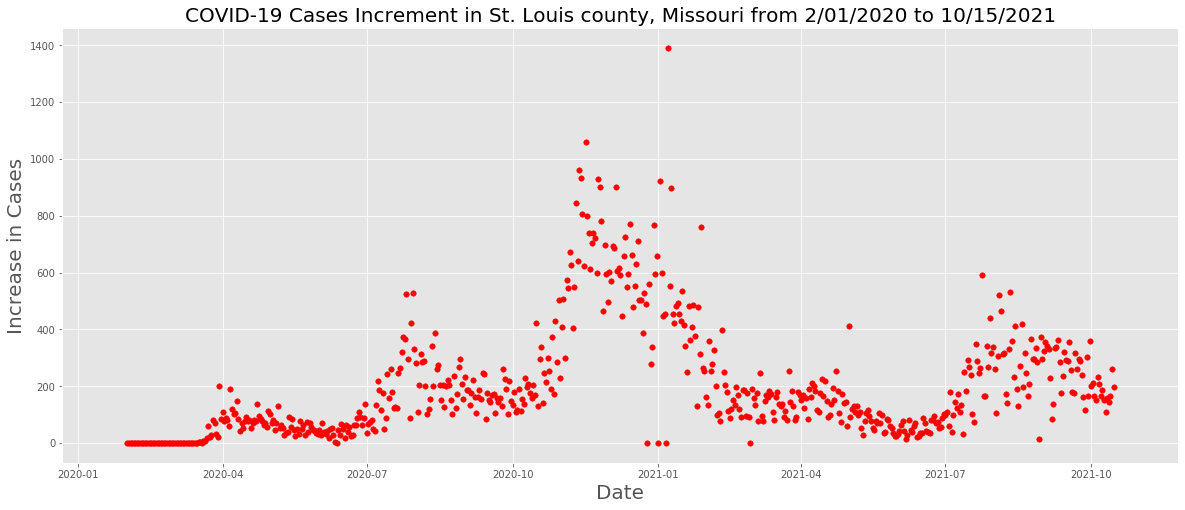

In [117]:
plt.figure(figsize=(20,8))
plt.scatter(st_louis_cases['Date'],st_louis_cases['Case_Increment'], s=30, color = 'red')
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Increase in Cases', fontsize = 20 )
plt.title('COVID-19 Cases Increment in St. Louis county, Missouri from 2/01/2020 to 10/15/2021', fontsize = 20)
plt.savefig('./final_data/Case_increase_over_time_stlouis.png')

### Step 2. CDC's Mask Mandate in St. Louis county, Missouri

Now, we'll take a look at how the mask mandate took effect in St. Louis county

In [132]:
mask_mandates.head(10)

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
0,AL,Autauga County,1,1,2020-04-10,2,NaN,NaN,NaN,NaN
1,AL,Autauga County,1,1,2020-04-11,2,NaN,NaN,NaN,NaN
2,AL,Autauga County,1,1,2020-04-12,2,NaN,NaN,NaN,NaN
3,AL,Autauga County,1,1,2020-04-13,2,NaN,NaN,NaN,NaN
4,AL,Autauga County,1,1,2020-04-14,2,NaN,NaN,NaN,NaN
5,AL,Autauga County,1,1,2020-04-15,2,NaN,NaN,NaN,NaN
6,AL,Autauga County,1,1,2020-04-16,2,NaN,NaN,NaN,NaN
7,AL,Autauga County,1,1,2020-04-17,2,NaN,NaN,NaN,NaN
8,AL,Autauga County,1,1,2020-04-18,2,NaN,NaN,NaN,NaN
9,AL,Autauga County,1,1,2020-04-19,2,NaN,NaN,NaN,NaN


In [133]:
# Looking at St. Louis County
st_louis_mandates = mask_mandates[(mask_mandates['County_Name'] == 'St. Louis County') & (mask_mandates['State_Tribe_Territory'] == 'MO')]
st_louis_mandates.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
419748,MO,St. Louis County,29,189,2020-04-10,2,NaN,NaN,NaN,NaN
419749,MO,St. Louis County,29,189,2020-04-11,2,NaN,NaN,NaN,NaN
419750,MO,St. Louis County,29,189,2020-04-12,2,NaN,NaN,NaN,NaN
419751,MO,St. Louis County,29,189,2020-04-13,2,NaN,NaN,NaN,NaN
419752,MO,St. Louis County,29,189,2020-04-14,2,NaN,NaN,NaN,NaN


In [134]:
# check unique values of the columns that are important for this analysis
st_louis_mandates[['order_code', 'Face_Masks_Required_in_Public', 'Source_of_Action', 'URL', 'Citation']].nunique()

order_code                       1
Face_Masks_Required_in_Public    0
Source_of_Action                 0
URL                              0
Citation                         0
dtype: int64

In [135]:
# subset dataframe based on two values for the order_code: 1 (Yes) or 2 (No)
st_louis_mandates = st_louis_mandates[(st_louis_mandates['order_code'] == 1) | (st_louis_mandates['order_code'] == 2)]
st_louis_mandates.head(10)

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
419748,MO,St. Louis County,29,189,2020-04-10,2,NaN,NaN,NaN,NaN
419749,MO,St. Louis County,29,189,2020-04-11,2,NaN,NaN,NaN,NaN
419750,MO,St. Louis County,29,189,2020-04-12,2,NaN,NaN,NaN,NaN
419751,MO,St. Louis County,29,189,2020-04-13,2,NaN,NaN,NaN,NaN
419752,MO,St. Louis County,29,189,2020-04-14,2,NaN,NaN,NaN,NaN
419753,MO,St. Louis County,29,189,2020-04-15,2,NaN,NaN,NaN,NaN
419754,MO,St. Louis County,29,189,2020-04-16,2,NaN,NaN,NaN,NaN
419755,MO,St. Louis County,29,189,2020-04-17,2,NaN,NaN,NaN,NaN
419756,MO,St. Louis County,29,189,2020-04-18,2,NaN,NaN,NaN,NaN
419757,MO,St. Louis County,29,189,2020-04-19,2,NaN,NaN,NaN,NaN


Here we'll create a new mapping protocol for the mask mandates and then plot that over time.

In [136]:
# Let's save this dataset in the final_data folder
st_louis_mandates.to_csv('./final_data/stlouis_mask_mandates.csv')

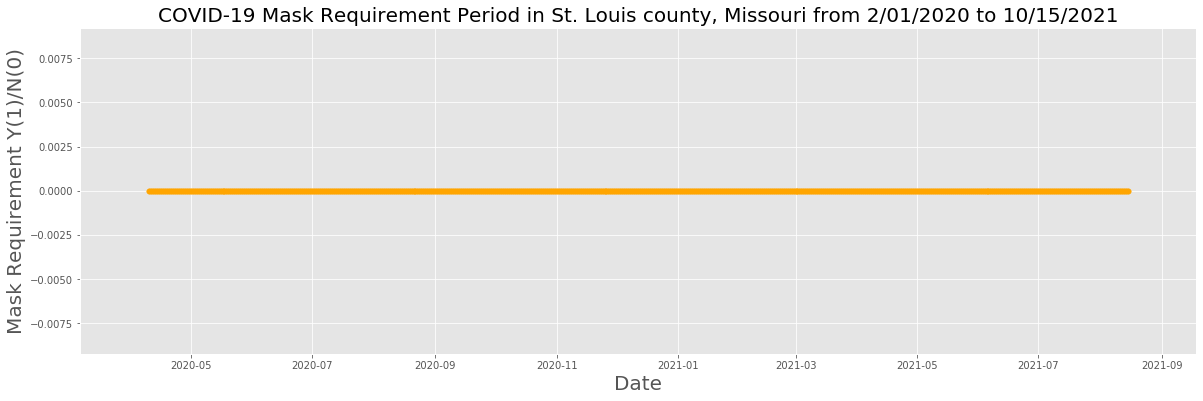

In [137]:
# map order_code from 1 (Yes) or 2 (No) to 1 or 0
st_louis_mandates['order_code'] = st_louis_mandates['order_code'].map({1:1, 2:0})

plt.figure(figsize=(20,6))
plt.scatter(st_louis_mandates['date'],st_louis_mandates['order_code'], s = 30, color = 'Orange')
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Mask Requirement Y(1)/N(0)', fontsize = 20 )
plt.title('COVID-19 Mask Requirement Period in St. Louis county, Missouri from 2/01/2020 to 10/15/2021', fontsize = 20)
plt.savefig('./final_data/mask_requirement_stlouis.png')

## Step 3. Dataset 3: the New York Times mask compliance survey data

Now we'll take a look at the mask compliance data for St. Louis county, Missouri

In [65]:
mask_compliance.head(10)

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459
5,1011,0.031,0.040,0.144,0.286,0.500
6,1013,0.102,0.053,0.257,0.137,0.451
7,1015,0.152,0.108,0.130,0.167,0.442
8,1017,0.117,0.037,0.150,0.136,0.560
9,1019,0.135,0.027,0.161,0.158,0.520


In [67]:
# rename 'COUNTYFP' to 'FIPS'
mask_compliance = mask_compliance.rename(columns = {'COUNTYFP':'FIPS'}).astype(str)

Now we'll combine this dataframe with that of the county level data we set up in step 1, merging only the location information of St. louis county from that dataframe

In [69]:
# reading in our cases by county dataframe that we saved in step 1. 
county_cases = pd.read_csv('./final_data/RAW_us_confirmed_cases_cleaned.csv')
county_cases = county_cases[['FIPS','Country','State','County']]
county_cases.head(10)

,FIPS,Country,State,County
0,1001.0,US,Alabama,Autauga
1,1001.0,US,Alabama,Autauga
2,1001.0,US,Alabama,Autauga
3,1001.0,US,Alabama,Autauga
4,1001.0,US,Alabama,Autauga
5,1001.0,US,Alabama,Autauga
6,1001.0,US,Alabama,Autauga
7,1001.0,US,Alabama,Autauga
8,1001.0,US,Alabama,Autauga
9,1001.0,US,Alabama,Autauga


In [71]:
# Now we'll ensure that the FIPS column is a string data type
county_cases = county_cases.fillna(0)
county_cases['FIPS'] = county_cases['FIPS'].astype(int)
county_cases['FIPS'] = county_cases['FIPS'].astype(str)

# remove potential duplicates
county_cases = county_cases.drop_duplicates()

county_cases

,FIPS,Country,State,County
0,1001,US,Alabama,Autauga
623,1003,US,Alabama,Baldwin
1246,1005,US,Alabama,Barbour
1869,1007,US,Alabama,Bibb
2492,1009,US,Alabama,Blount
...,...,...,...,...
2078951,56039,US,Wyoming,Teton
2079574,56041,US,Wyoming,Uinta
2080197,90056,US,Wyoming,Unassigned
2080820,56043,US,Wyoming,Washakie


In [74]:
#merge two data frame and get county and state names
county_cases_merged = pd.merge(mask_compliance, county_cases, on = 'FIPS')
county_cases_merged.head(10)

,FIPS,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,Country,State,County
0,1001,0.053,0.07400000000000001,0.134,0.295,0.444,US,Alabama,Autauga
1,1003,0.083,0.059000000000000004,0.098,0.32299999999999995,0.436,US,Alabama,Baldwin
2,1005,0.067,0.121,0.12,0.201,0.491,US,Alabama,Barbour
3,1007,0.02,0.034,0.096,0.278,0.5720000000000001,US,Alabama,Bibb
4,1009,0.053,0.114,0.18,0.19399999999999998,0.45899999999999996,US,Alabama,Blount
5,1011,0.031,0.04,0.14400000000000002,0.28600000000000003,0.5,US,Alabama,Bullock
6,1013,0.102,0.053,0.257,0.13699999999999998,0.451,US,Alabama,Butler
7,1015,0.152,0.10800000000000001,0.13,0.16699999999999998,0.442,US,Alabama,Calhoun
8,1017,0.11699999999999999,0.037000000000000005,0.15,0.136,0.56,US,Alabama,Chambers
9,1019,0.135,0.027000000000000003,0.161,0.158,0.52,US,Alabama,Cherokee


Now that we have our merged mask compliance dataframe, let's look at St. Louis county specifically

In [77]:
county_cases_merged_stlouis = county_cases_merged[(county_cases_merged['State'] == 'Missouri') & (county_cases_merged['County'] == 'St. Louis')]
county_cases_merged_stlouis = county_cases_merged_stlouis.drop_duplicates()
county_cases_merged_stlouis

,FIPS,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,Country,State,County
1578,29189,0.024,0.027999999999999997,0.069,0.182,0.6970000000000001,US,Missouri,St. Louis


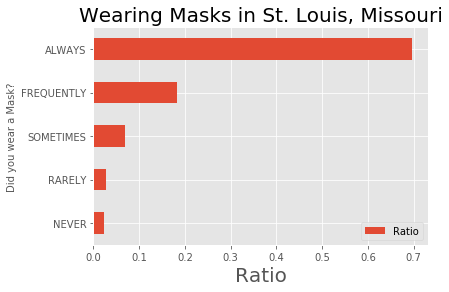

In [140]:
# let's save this figure
county_cases_merged_stlouis.to_csv('./final_data/mask_survey_stlouis.csv')

#graph
columns = list(county_cases_merged_stlouis.columns[1:6].values)
values = [0.024, 0.028, 0.069, 0.182, 0.697]
stlouis_rations = pd.DataFrame({'Labels': columns, 'Ratio': values})
stlouis_rations.plot.barh(x='Labels', y='Ratio', stacked=True)
plt.xlabel('Ratio', fontsize = 20)
plt.ylabel('Did you wear a Mask?', fontsize = 10 )
plt.title('Wearing Masks in St. Louis, Missouri', fontsize = 20)
plt.savefig('./final_data/mask_policy_survey.png')